# **Find shape of the Galactic halo with Gaia DR2 RR Lyrae** 

Authors : Irfan Imaduddin <br>
Version : 1.0 <br>
Date : 3 April 2021 <br>
Contact : irfanimaduddin[at]gmail[dot]com <br>
Reference : Iorio & Belokurov (2019), MNRAS, 482, 3868

---

Import necessary modules

In [1]:
from astropy.coordinates import SkyCoord

import astropy.units as u
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Set some plotting configurations

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)            # legend fontsize

%matplotlib inline

Import necessary files

In [3]:
field     = pd.read_csv("rrl_query.csv", delimiter=",")
glob_info = pd.read_csv("glob_info.txt", delimiter=",")
dsph_info = pd.read_csv("dsph_info.txt", delimiter=",")

Inspect column names of each file

In [4]:
l_all = []

for i in range(len(field)):
    if field.l[i] > 180.:
        l_all.append(field.l[i]-360.)
    else:
        l_all.append(field.l[i])

#### Plot the data for early information

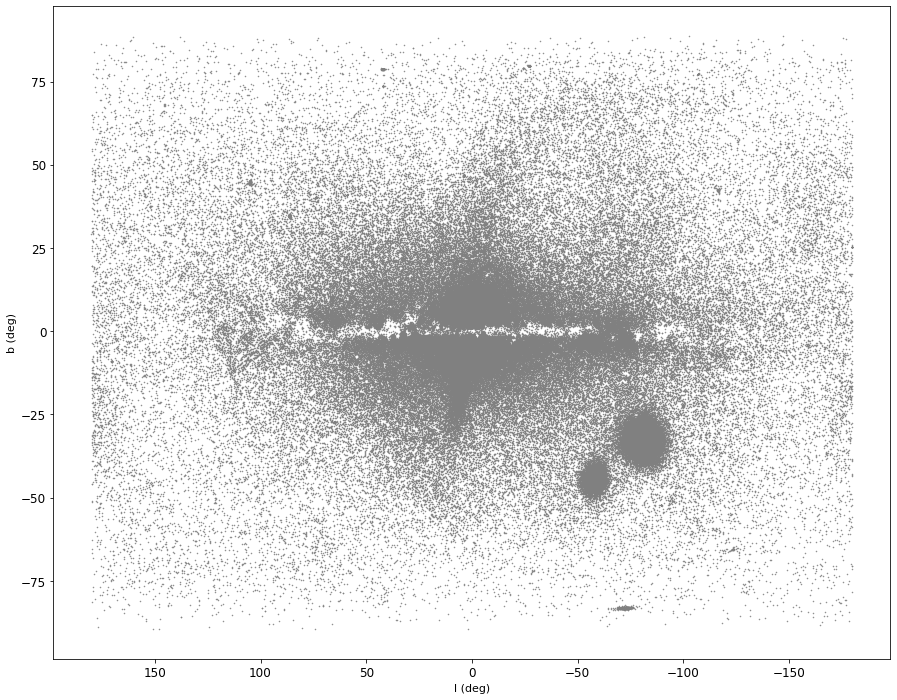

In [5]:
fig = plt.figure(figsize=(15, 12))
plt.plot(l_all, field.b, '.', color='gray', markersize=1.)
plt.xlabel("l (deg)", fontsize=11.)
plt.ylabel("b (deg)", fontsize=11.)
plt.gca().invert_xaxis()

Define coordinates from data

In [6]:
field_coord = SkyCoord(ra=field.ra, dec=field.dec, frame='icrs', unit=(u.deg, u.deg), obstime='J2015.5 ')

Define globular clusters to be removed from the data

In [7]:
glob_coord = SkyCoord(ra=glob_info.RA, dec=glob_info.DEC, frame='icrs', unit=(u.hourangle, u.deg), obstime='J2000.0')

In [8]:
field_glob = pd.DataFrame()

for i in range(len(glob_coord)):
    a = field[field_coord.separation(glob_coord[i]) < 2.*glob_info.r_h[i]*u.arcmin]
    field_glob = field_glob.append(a).reset_index(drop=True)

In [9]:
l_glob = []

for i in range(len(field_glob)):
    if field_glob.l[i] > 180.:
        l_glob.append(field_glob.l[i]-360.)
    else:
        l_glob.append(field_glob.l[i])

Check globular cluster distribution

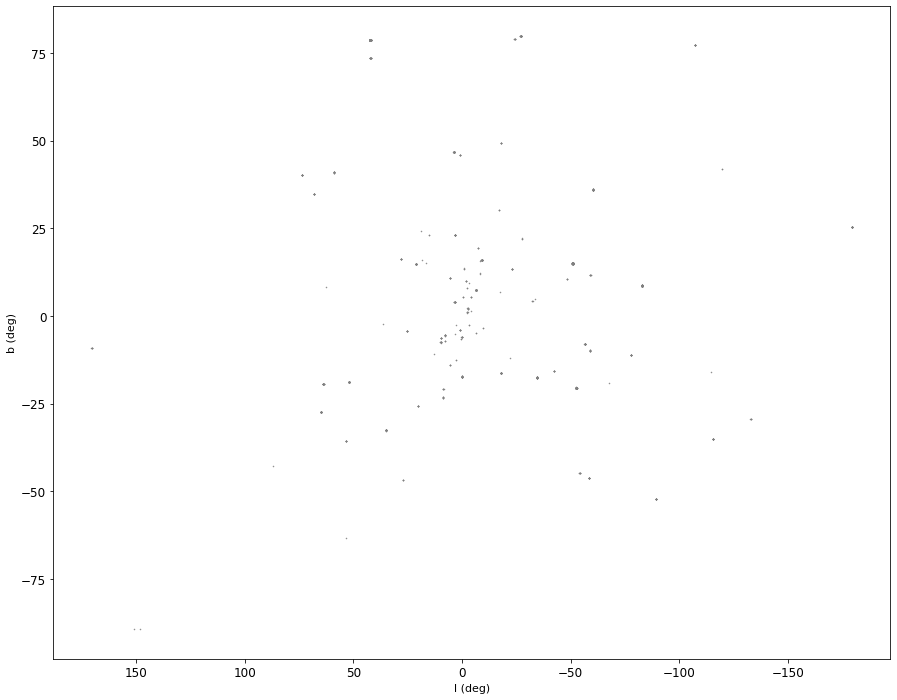

In [10]:
fig = plt.figure(figsize=(15, 12))
plt.plot(l_glob, field_glob.b, '.', color='gray', markersize=1.)
plt.xlabel("l (deg)", fontsize=11.)
plt.ylabel("b (deg)", fontsize=11.)
# plt.xlim([0., 360.])
# plt.ylim([-90., 90.])
plt.gca().invert_xaxis()

Define dwarf spheroidal galaxy (dSph) to be removed from the data

In [11]:
dsph_coord = SkyCoord(ra=dsph_info.RA, dec=dsph_info.DEC, frame='icrs', unit=(u.hourangle, u.deg), obstime='J2000.0')

In [12]:
field_dsph = pd.DataFrame()

for i in range(len(dsph_coord)):
    a = field[field_coord.separation(dsph_coord[i]) < dsph_info.ang_dist[i]*u.deg]
    field_dsph = field_dsph.append(a).reset_index(drop=True)

In [13]:
l_dsph = []

for i in range(len(field_dsph)):
    if field_dsph.l[i] > 180.:
        l_dsph.append(field_dsph.l[i]-360.)
    else:
        l_dsph.append(field_dsph.l[i])

Check(dSph) distribution

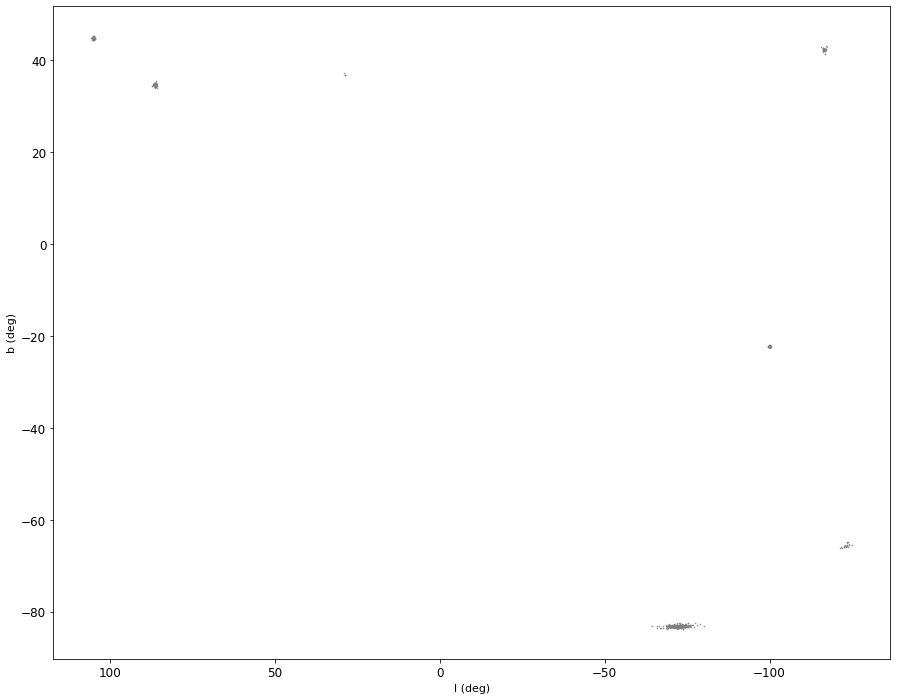

In [14]:
fig = plt.figure(figsize=(15, 12))
plt.plot(l_dsph, field_dsph.b, '.', color='gray', markersize=1.)
plt.xlabel("l (deg)", fontsize=11.)
plt.ylabel("b (deg)", fontsize=11.)
# plt.xlim([0., 360.])
# plt.ylim([-90., 90.])
plt.gca().invert_xaxis()

Define Sagittarius dwarf to be removed from the data

In [15]:
sgr_cen_long, sgr_cen_lat = 1.55, 4.24

In [16]:
def sgr(ra, dec):
    sgr_long_y = (-0.93595354*math.cos(ra)*math.cos(dec))-(0.31910658*math.sin(ra)*math.cos(dec))+(0.14886895*math.sin(dec))
    sgr_long_x = (0.21215555*math.cos(ra)*math.cos(dec))-(0.84846291*math.sin(ra)*math.cos(dec))-(0.48487186*math.sin(dec))

    sgr_long   = math.atan2(sgr_long_y, sgr_long_x)
    sgr_lat    = math.asin((0.28103559*math.cos(ra)*math.cos(dec))-(0.42223415*math.sin(ra)*math.cos(dec))+(0.86182209*math.sin(dec)))
    return sgr_long, sgr_lat

In [17]:
sgr_val = []

for i in range(len(field_coord)):
    sgr_val.append(sgr(field_coord.ra[i].rad, field_coord.dec[i].rad))

In [18]:
sgr_long, sgr_lat = [], []

for i in range(len(sgr_val)):
    sgr_long.append(np.rad2deg(sgr_val[i][0]))
    sgr_lat.append(np.rad2deg(sgr_val[i][1]))

In [19]:
sgr_prel_dict = {
    'sgr_long' : sgr_long,
    'sgr_lat' : sgr_lat,
}

sgr_prel = pd.DataFrame(sgr_prel_dict)

In [20]:
sgr_secprel = field[(abs(sgr_prel.sgr_long-sgr_cen_long) < 50.) & (abs(sgr_prel.sgr_lat-sgr_cen_lat) < 10.)].reset_index(drop=True)

In [21]:
sgr_cen_pmra, sgr_cen_pmdec = -2.692, -1.359
pm_a, pm_b = 1.3, 1.3
t          = np.linspace(0, 2*np.pi, 100)
t_rot      = np.deg2rad(0.) #rotation angle

In [22]:
Ell = np.array([pm_a*np.cos(t), pm_b*np.sin(t)]) #u,v removed to keep the same center location
R_rot = np.array([[np.cos(t_rot), -np.sin(t_rot)],[np.sin(t_rot), np.cos(t_rot)]]) #2-D rotation matrix

Ell_rot = np.zeros((2,Ell.shape[1]))
for i in range(Ell.shape[1]):
    Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])

Check Sagittarius dwarf distribution

(-4.0, 1.0)

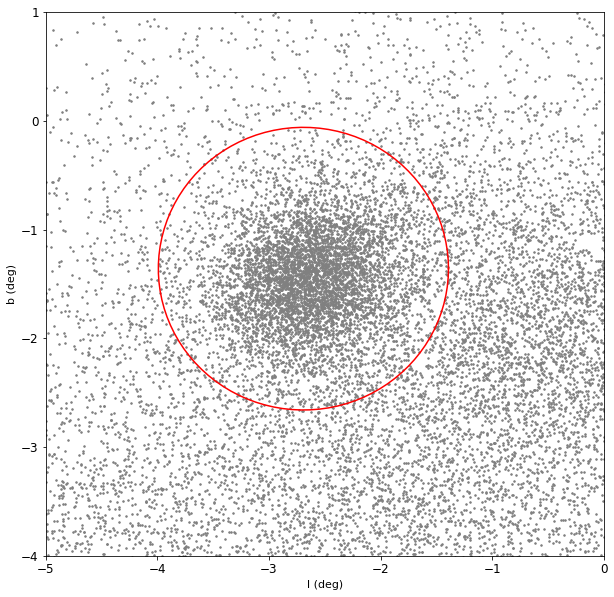

In [26]:
fig = plt.figure(figsize=(10, 10))
plt.plot(sgr_secprel.pmra, sgr_secprel.pmdec, '.', color='gray', markersize=3.)
plt.plot(sgr_cen_pmra+Ell_rot[0,:], sgr_cen_pmdec+Ell_rot[1,:], 'r', markersize=3.)    #rotated ellipse
plt.xlabel("l (deg)", fontsize=11.)
plt.ylabel("b (deg)", fontsize=11.)
plt.xlim([-5., 0.])
plt.ylim([-4., 1.])
# plt.gca().invert_xaxis()

In [27]:
xct = ((sgr_secprel.pmra - sgr_cen_pmra) * np.cos(t_rot)) + ((sgr_secprel.pmdec - sgr_cen_pmdec) * np.sin(t_rot))
yct = ((sgr_secprel.pmra - sgr_cen_pmra) * np.sin(t_rot)) - ((sgr_secprel.pmdec - sgr_cen_pmdec) * np.cos(t_rot)) 

rad_cc = (xct**2/pm_a/pm_a) + (yct**2/pm_b/pm_b)

field_sgr = sgr_secprel[(rad_cc <= 1.)].reset_index(drop=True)

In [28]:
l_sgr = []

for i in range(len(field_sgr)):
    if field_sgr.l[i] > 180.:
        l_sgr.append(field_sgr.l[i]-360.)
    else:
        l_sgr.append(field_sgr.l[i])

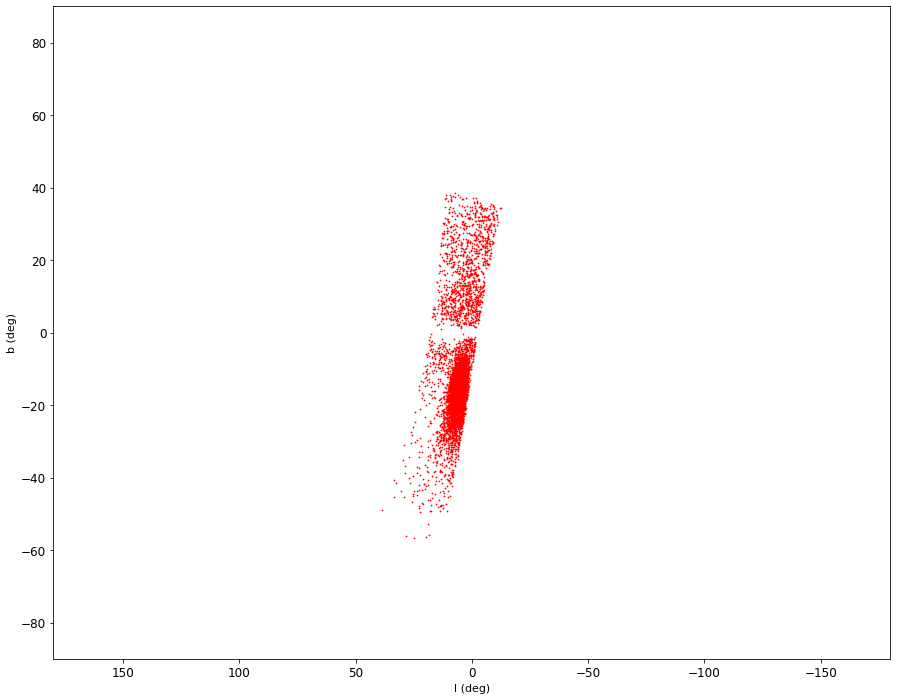

In [29]:
fig = plt.figure(figsize=(15, 12))
plt.plot(l_sgr, field_sgr.b, '.', color='r', markersize=1.5)
plt.xlabel("l (deg)", fontsize=11.)
plt.ylabel("b (deg)", fontsize=11.)
plt.xlim([-180., 180.])
plt.ylim([-90., 90.])
plt.gca().invert_xaxis()

Define LMC and SMC to be removed from the data

In [30]:
lmc_cen = SkyCoord(ra='05 23 34.6', dec='-69 45 22', frame='icrs', unit=(u.hourangle, u.deg), obstime='J2000.0')
smc_cen = SkyCoord(ra='00 52 38.0', dec='-72 48 01', frame='icrs', unit=(u.hourangle, u.deg), obstime='J2000.0')

In [31]:
lmc_prel = field[field_coord.separation(lmc_cen) < 16.*u.deg].reset_index(drop=True)
smc_prel = field[field_coord.separation(smc_cen) < 12.*u.deg].reset_index(drop=True)

In [32]:
l_lmc_prel, l_smc_prel = [], []

for i in range(len(lmc_prel)):
    if lmc_prel.l[i] > 180.:
        l_lmc_prel.append(lmc_prel.l[i]-360.)
    else:
        l_lmc_prel.append(lmc_prel.l[i])
        
for i in range(len(smc_prel)):
    if smc_prel.l[i] > 180.:
        l_smc_prel.append(smc_prel.l[i]-360.)
    else:
        l_smc_prel.append(smc_prel.l[i])

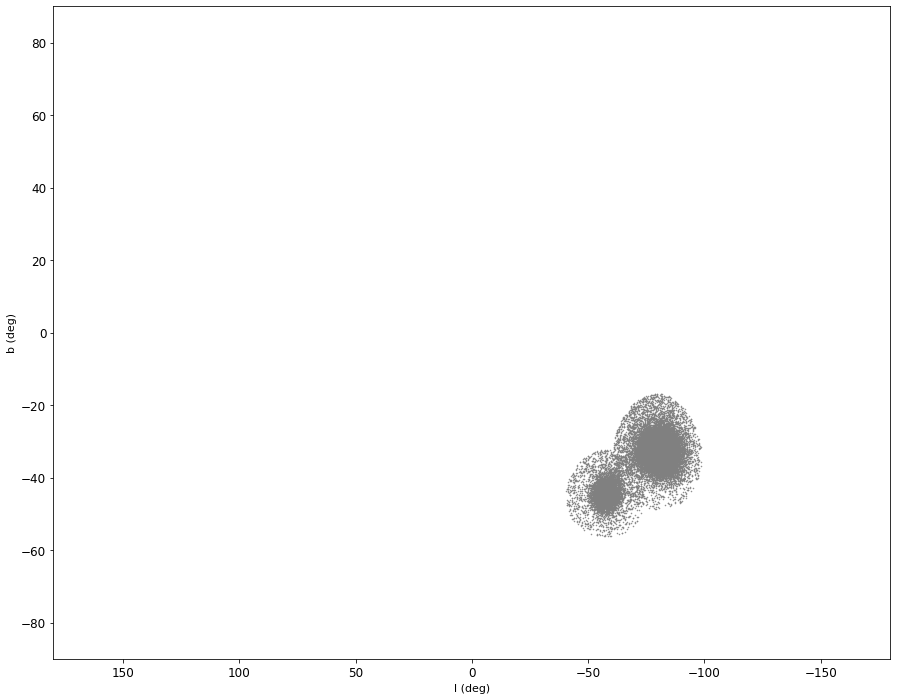

In [33]:
fig = plt.figure(figsize=(15, 12))
plt.plot(l_lmc_prel, lmc_prel.b, '.', color='gray', markersize=1.)
plt.plot(l_smc_prel, smc_prel.b, '.', color='gray', markersize=1.)
plt.xlabel("l (deg)", fontsize=11.)
plt.ylabel("b (deg)", fontsize=11.)
plt.xlim([-180., 180.])
plt.ylim([-90., 90.])
plt.gca().invert_xaxis()

In [34]:
lmc_cen_pmra, lmc_cen_pmdec = 1.872, 0.224
smc_cen_pmra, smc_cen_pmdec = 0.874, -1.229
pm_a, pm_b = 5., 5.
t          = np.linspace(0, 2*np.pi, 100)
t_rot      = np.deg2rad(0.) #rotation angle

In [35]:
Ell = np.array([pm_a*np.cos(t), pm_b*np.sin(t)]) #u,v removed to keep the same center location
R_rot = np.array([[np.cos(t_rot), -np.sin(t_rot)],[np.sin(t_rot), np.cos(t_rot)]]) #2-D rotation matrix

Ell_rot = np.zeros((2,Ell.shape[1]))
for i in range(Ell.shape[1]):
    Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])

(-7.0, 8.0)

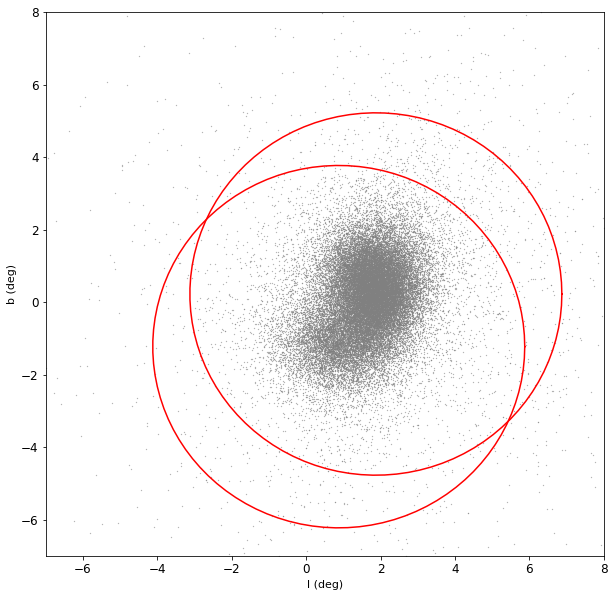

In [36]:
fig = plt.figure(figsize=(10, 10))
plt.plot(lmc_prel.pmra, lmc_prel.pmdec, '.', color='gray', markersize=.5)
plt.plot(smc_prel.pmra, smc_prel.pmdec, '.', color='gray', markersize=.5)
plt.plot(lmc_cen_pmra+Ell_rot[0,:], lmc_cen_pmdec+Ell_rot[1,:], 'r', markersize=3.)    #rotated ellipse
plt.plot(smc_cen_pmra+Ell_rot[0,:], smc_cen_pmdec+Ell_rot[1,:], 'r', markersize=3.)    #rotated ellipse
plt.xlabel("l (deg)", fontsize=11.)
plt.ylabel("b (deg)", fontsize=11.)
plt.xlim([-7., 8.])
plt.ylim([-7., 8.])
# plt.gca().invert_xaxis()

In [37]:
lmc_xct = ((lmc_prel.pmra - lmc_cen_pmra) * np.cos(t_rot)) + ((lmc_prel.pmdec - lmc_cen_pmdec) * np.sin(t_rot))
lmc_yct = ((lmc_prel.pmra - lmc_cen_pmra) * np.sin(t_rot)) - ((lmc_prel.pmdec - lmc_cen_pmdec) * np.cos(t_rot)) 
smc_xct = ((smc_prel.pmra - smc_cen_pmra) * np.cos(t_rot)) + ((smc_prel.pmdec - smc_cen_pmdec) * np.sin(t_rot))
smc_yct = ((smc_prel.pmra - smc_cen_pmra) * np.sin(t_rot)) - ((smc_prel.pmdec - smc_cen_pmdec) * np.cos(t_rot))

lmc_rad = (lmc_xct**2/pm_a/pm_a) + (lmc_yct**2/pm_b/pm_b)
smc_rad = (smc_xct**2/pm_a/pm_a) + (smc_yct**2/pm_b/pm_b)

field_lmc_1 = lmc_prel[(lmc_rad <= 1.) & (lmc_prel.phot_g_mean_mag > 18.) & (lmc_prel.phot_g_mean_mag < 20.)].reset_index(drop=True)
field_smc_1 = smc_prel[(smc_rad <= 1.) & (smc_prel.phot_g_mean_mag > 18.) & (smc_prel.phot_g_mean_mag < 20.)].reset_index(drop=True)

In [38]:
field_lmc_2 = field[field_coord.separation(lmc_cen) < 5.*u.deg].reset_index(drop=True)
field_smc_2 = field[field_coord.separation(smc_cen) < 5.*u.deg].reset_index(drop=True)

In [39]:
inner_lmc = pd.merge(field_lmc_1, field_lmc_2, on='source_id')
inner_smc = pd.merge(field_smc_1, field_smc_2, on='source_id')

In [40]:
lmc_drop = field_lmc_2[~field_lmc_2.source_id.isin(inner_lmc.source_id)].reset_index(drop=True)
smc_drop = field_smc_2[~field_smc_2.source_id.isin(inner_smc.source_id)].reset_index(drop=True)

In [41]:
field_lmc = pd.concat([field_lmc_1, lmc_drop]).reset_index(drop=True)
field_smc = pd.concat([field_smc_1, smc_drop]).reset_index(drop=True)

In [42]:
inner_magcloud = pd.merge(field_lmc, field_smc, on='source_id')

In [43]:
magcloud_drop = field_lmc[~field_lmc.source_id.isin(inner_magcloud.source_id)].reset_index(drop=True)

In [44]:
field_magcloud = pd.concat([field_smc, magcloud_drop]).reset_index(drop=True)

In [45]:
l_lmc, l_smc = [], []
l_magcloud = []

for i in range(len(field_lmc)):
    if field_lmc.l[i] > 180.:
        l_lmc.append(field_lmc.l[i]-360.)
    else:
        l_lmc.append(field_lmc.l[i])

for i in range(len(field_smc)):
    if field_smc.l[i] > 180.:
        l_smc.append(field_smc.l[i]-360.)
    else:
        l_smc.append(field_smc.l[i])

for i in range(len(field_magcloud)):
    if field_magcloud.l[i] > 180.:
        l_magcloud.append(field_magcloud.l[i]-360.)
    else:
        l_magcloud.append(field_magcloud.l[i])

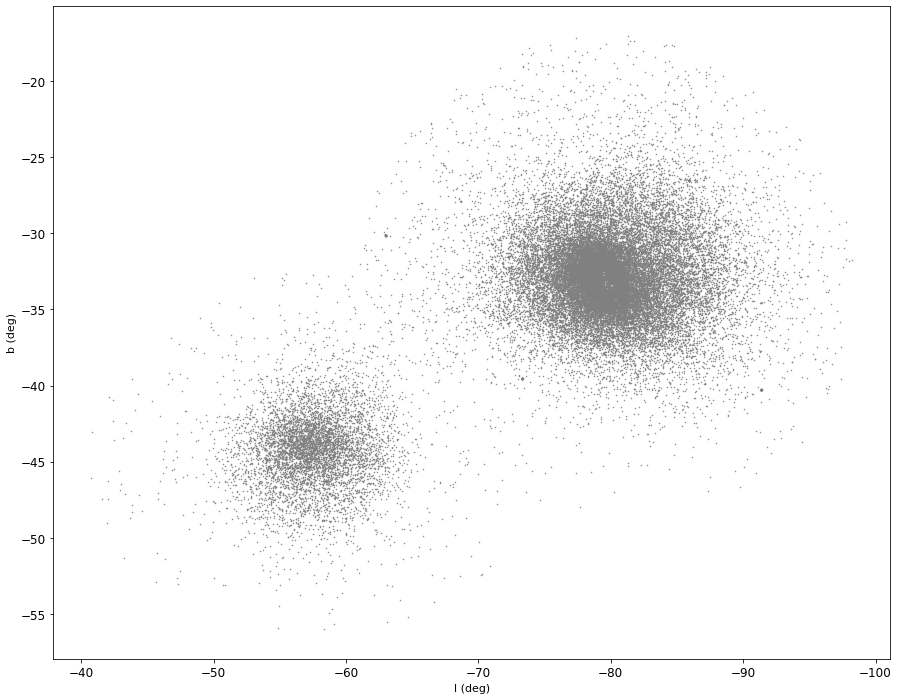

In [46]:
fig = plt.figure(figsize=(15, 12))
plt.plot(l_magcloud, field_magcloud.b, '.', color='gray', markersize=1.)
# plt.plot(l_lmc, field_lmc.b, '.', color='r', markersize=1.)
# plt.plot(l_smc, field_smc.b, '.', color='b', markersize=1.)
plt.xlabel("l (deg)", fontsize=11.)
plt.ylabel("b (deg)", fontsize=11.)
# plt.xlim([-180., 180.])
# plt.ylim([-90., 90.])
plt.gca().invert_xaxis()

Plot all rejected RRL stars in galactic coordinate

In [47]:
sample = field[(~field.source_id.isin(field_glob.source_id)) & 
               (~field.source_id.isin(field_dsph.source_id)) & 
               (~field.source_id.isin(field_sgr.source_id)) & 
               (~field.source_id.isin(field_magcloud.source_id))].reset_index(drop=True)

In [48]:
len(sample), len(field_glob)+len(field_dsph)+len(field_sgr)+len(field_magcloud), len(field)-len(field_glob)-len(field_dsph)-len(field_sgr)-len(field_magcloud)

(181908, 47030, 181874)

In [49]:
l_sample = []

for i in range(len(sample)):
    if sample.l[i] > 180.:
        l_sample.append(sample.l[i]-360.)
    else:
        l_sample.append(sample.l[i])

In [50]:
sample_prel_clean = sample[(sample.astrometric_excess_noise < .25) & (sample.phot_bp_rp_excess_factor < 1.5)].reset_index(drop=True)
sample_aen_bre    = sample[(sample.astrometric_excess_noise > .25) & (sample.phot_bp_rp_excess_factor > 1.5)].reset_index(drop=True)

In [51]:
sample_ebv = sample_prel_clean[sample_prel_clean.a_g_val/2.27 >= .8].reset_index(drop=True)

In [52]:
sample_clean = sample_prel_clean[~(sample_prel_clean.source_id.isin(sample_ebv.source_id)) & (sample_prel_clean.parallax.notnull()) & (sample_prel_clean.phot_g_mean_mag.notnull())].reset_index(drop=True)

In [53]:
l_sclean, l_saenbre, l_sebv = [], [], []

for i in range(len(sample_clean)):
    if sample_clean.l[i] > 180.:
        l_sclean.append(sample_clean.l[i]-360.)
    else:
        l_sclean.append(sample_clean.l[i])
        
for i in range(len(sample_aen_bre)):
    if sample_aen_bre.l[i] > 180.:
        l_saenbre.append(sample_aen_bre.l[i]-360.)
    else:
        l_saenbre.append(sample_aen_bre.l[i])
        
for i in range(len(sample_ebv)):
    if sample_ebv.l[i] > 180.:
        l_sebv.append(sample_ebv.l[i]-360.)
    else:
        l_sebv.append(sample_ebv.l[i])

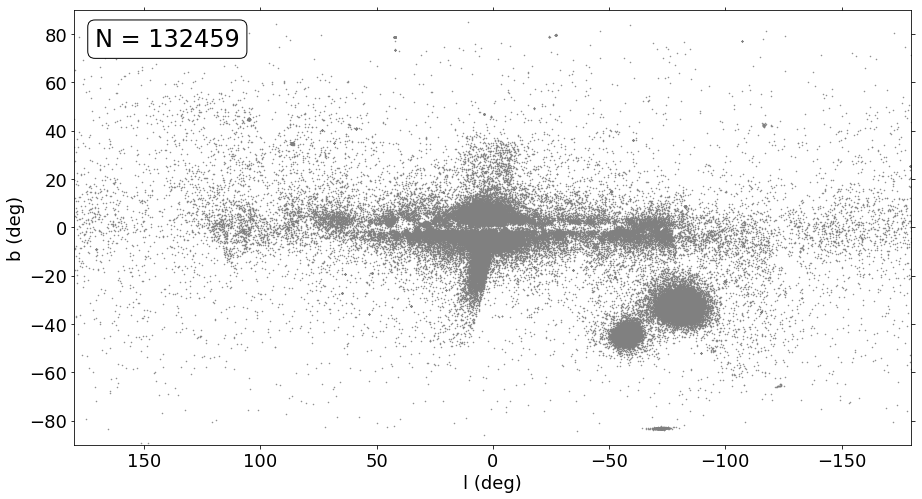

In [54]:
fig, ax = plt.subplots(figsize=(15, 8))
# ax.plot(l_all, field.b, '.', color='gray', markersize=1.)
# ax.plot(l_sclean, sample_clean.b, '.', color='gray', markersize=1.)
ax.plot(l_saenbre, sample_aen_bre.b, '.', color='gray', markersize=1.)
ax.plot(l_sebv, sample_ebv.b, '.', color='gray', markersize=1.)
ax.plot(l_glob, field_glob.b, '.', color='gray', markersize=1.)
ax.plot(l_dsph, field_dsph.b, '.', color='gray', markersize=1.)
ax.plot(l_sgr, field_sgr.b, '.', color='gray', markersize=1.)
ax.plot(l_magcloud, field_magcloud.b, '.', color='gray', markersize=1.)
ax.set_xlabel("l (deg)", fontsize=18.)
ax.set_ylabel("b (deg)", fontsize=18.)
ax.set_xlim([-180., 180.])
ax.set_ylim([-90., 90.])
plt.gca().invert_xaxis()

# ax.annotate("N = %s"%(len(field)), 
#             xy=(140, 75), xycoords='data', bbox=dict(boxstyle="round", fc="white", ec="black"),
#             xytext=(0., 0.), textcoords='offset points', ha='center', fontsize=24.)
# ax.annotate("N = %s"%(len(sample_clean)), 
#             xy=(145, 75), xycoords='data', bbox=dict(boxstyle="round", fc="white", ec="black"),
#             xytext=(0., 0.), textcoords='offset points', ha='center', fontsize=24.)
ax.annotate("N = 132459",
            xy=(140, 75), xycoords='data', bbox=dict(boxstyle="round", fc="white", ec="black"),
            xytext=(0., 0.), textcoords='offset points', ha='center', fontsize=24.)
# ax.annotate("N = %s"%(len(field_glob)+len(field_dsph)+len(field_sgr)+len(field_magcloud)), 
#             xy=(145, 75), xycoords='data', bbox=dict(boxstyle="round", fc="white", ec="black"),
#             xytext=(0., 0.), textcoords='offset points', ha='center', fontsize=24.)


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=True, labelsize=18.) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off
    labelbottom=True, labelsize=18.) # labels along the bottom edge are off

# plt.savefig('field.png', dpi=300, bbox_inches='tight')
# plt.savefig('sample.png', dpi=300, bbox_inches='tight')
# plt.savefig('reject.png', dpi=300, bbox_inches='tight')
# plt.savefig('gcdwarf.png', dpi=300, bbox_inches='tight')

## Distance of the Sample

\begin{eqnarray}
X_g &=& X_{g, \odot} - & D_{\odot} & cos & b & cos& l \\
Y_g &=& &D_{\odot} & cos & b & sin & l \\
Z_g &=& &D_{\odot} & sin & b \\
\end{eqnarray}

In [55]:
Xg_sun = 8. #kpc

dist = 10**(((sample_clean.phot_g_mean_mag - 0.64)/5.)-2.)
# dist = 10**(-np.log10(sample_filt_par.parallax))

In [56]:
clean_coord = SkyCoord(ra=sample_clean.ra, dec=sample_clean.dec, distance=dist, frame='icrs', unit=(u.deg, u.deg), obstime='J2015.5')

In [57]:
sample_b = clean_coord.galactic.b.deg
sample_l = clean_coord.galactic.l.deg

In [58]:
Xg, Yg, Zg = [], [], []

for i in range(len(clean_coord)):
    Xg.append(8. - (dist[i] * math.cos(np.deg2rad(sample_b[i])) * math.cos(np.deg2rad(sample_l[i]))))
    Yg.append(dist[i] * math.cos(np.deg2rad(sample_b[i])) * math.sin(np.deg2rad(sample_l[i])))
    Zg.append(dist[i] * math.sin(np.deg2rad(sample_b[i])))

In [59]:
kart_dict = {
    'source_id' : sample_clean.source_id,
    'dist' : dist,
    'Xg' : Xg,
    'Yg' : Yg,
    'Zg' : Zg
}

kart_ = pd.DataFrame(kart_dict)

In [60]:
z_m30_m10 = kart_[(kart_.Zg > -30.) & (kart_.Zg < -10.)].reset_index(drop=True)
z_m10_m05 = kart_[(kart_.Zg > -10.) & (kart_.Zg < -5.)].reset_index(drop=True)
z_m05_p00 = kart_[(kart_.Zg > -5.) & (kart_.Zg < 0.)].reset_index(drop=True)
z_p00_p05 = kart_[(kart_.Zg > 0.) & (kart_.Zg < 5.)].reset_index(drop=True)
z_p05_p10 = kart_[(kart_.Zg > 5.) & (kart_.Zg < 10.)].reset_index(drop=True)
z_p10_p30 = kart_[(kart_.Zg > 10.) & (kart_.Zg < 30.)].reset_index(drop=True)

z_05_30 = kart_[(abs(kart_.Zg) > 5.) & (abs(kart_.Zg) < 30.)].reset_index(drop=True)

In [61]:
step = np.arange(-50., 50., .1)

val = []

for i in range(len(step)):
    val.append(0.)

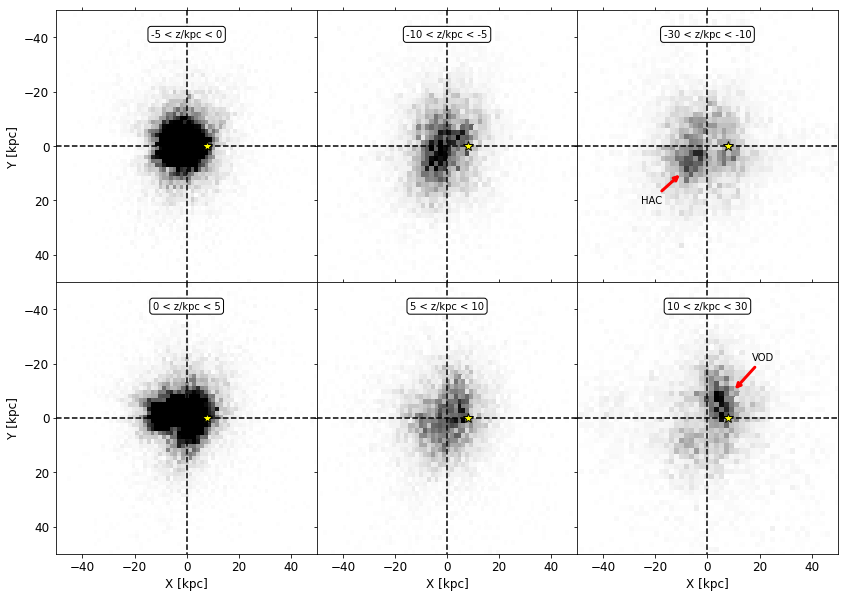

<Figure size 432x288 with 0 Axes>

In [62]:
from matplotlib.colors import PowerNorm, LogNorm
from matplotlib import cm

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
ax[0,0].hist2d(z_m05_p00.Xg, z_m05_p00.Yg, bins=100, vmin=.0001, vmax=50, cmap=plt.cm.Greys)
ax[0,0].plot(step, val, 'k--', markersize=1.)
ax[0,0].plot(val, step, 'k--', markersize=1.)
ax[0,0].plot(8., 0., '*', mfc='yellow', mec='k', markersize=10.)
ax[0,1].hist2d(z_m10_m05.Xg, z_m10_m05.Yg, bins=100, vmin=.0001, vmax=50, cmap=plt.cm.Greys)
ax[0,1].plot(step, val, 'k--', markersize=1.)
ax[0,1].plot(val, step, 'k--', markersize=1.)
ax[0,1].plot(8., 0., '*', mfc='yellow', mec='k', markersize=10.)
ax[0,2].hist2d(z_m30_m10.Xg, z_m30_m10.Yg, bins=100, vmin=.0001, vmax=50, cmap=plt.cm.Greys)
ax[0,2].plot(step, val, 'k--', markersize=1.)
ax[0,2].plot(val, step, 'k--', markersize=1.)
ax[0,2].plot(8., 0., '*', mfc='yellow', mec='k', markersize=10.)
ax[1,0].hist2d(z_p00_p05.Xg, z_p00_p05.Yg, bins=100, vmin=.0001, vmax=50, cmap=plt.cm.Greys)
ax[1,0].plot(step, val, 'k--', markersize=1.)
ax[1,0].plot(val, step, 'k--', markersize=1.)
ax[1,0].plot(8., 0., '*', mfc='yellow', mec='k', markersize=10.)
ax[1,1].hist2d(z_p05_p10.Xg, z_p05_p10.Yg, bins=100, vmin=.0001, vmax=50, cmap=plt.cm.Greys)
ax[1,1].plot(step, val, 'k--', markersize=1.)
ax[1,1].plot(val, step, 'k--', markersize=1.)
ax[1,1].plot(8., 0., '*', mfc='yellow', mec='k', markersize=10.)
ax[1,2].hist2d(z_p10_p30.Xg, z_p10_p30.Yg, bins=100, vmin=.0001, vmax=50, cmap=plt.cm.Greys)
ax[1,2].plot(step, val, 'k--', markersize=1.)
ax[1,2].plot(val, step, 'k--', markersize=1.)
ax[1,2].plot(8., 0., '*', mfc='yellow', mec='k', markersize=10.)


ax[0,0].set_xlim([-50., 50.])
ax[0,0].set_ylim([50., -50.])
ax[0,1].set_xlim([-50., 50.])
ax[0,1].set_ylim([50., -50.])
ax[0,2].set_xlim([-50., 50.])
ax[0,2].set_ylim([50., -50.])
ax[1,0].set_xlim([-50., 50.])
ax[1,0].set_ylim([50., -50.])
ax[1,1].set_xlim([-50., 50.])
ax[1,1].set_ylim([50., -50.])
ax[1,2].set_xlim([-50., 50.])
ax[1,2].set_ylim([50., -50.])

ax[0,0].annotate("-5 < z/kpc < 0", xy=(0, -40),  xycoords='data',
            bbox=dict(boxstyle="round", fc="white", ec="black"),
            xytext=(0., 0.), textcoords='offset points', ha='center')
ax[0,1].annotate("-10 < z/kpc < -5", xy=(0, -40),  xycoords='data',
            bbox=dict(boxstyle="round", fc="white", ec="black"),
            xytext=(0., 0.), textcoords='offset points', ha='center')
ax[0,2].annotate("-30 < z/kpc < -10", xy=(0, -40),  xycoords='data',
            bbox=dict(boxstyle="round", fc="white", ec="black"),
            xytext=(0., 0.), textcoords='offset points', ha='center')
ax[1,0].annotate("0 < z/kpc < 5", xy=(0, -40),  xycoords='data',
            bbox=dict(boxstyle="round", fc="white", ec="black"),
            xytext=(0., 0.), textcoords='offset points', ha='center')
ax[1,1].annotate("5 < z/kpc < 10", xy=(0, -40),  xycoords='data',
            bbox=dict(boxstyle="round", fc="white", ec="black"),
            xytext=(0., 0.), textcoords='offset points', ha='center')
ax[1,2].annotate("10 < z/kpc < 30", xy=(0, -40),  xycoords='data',
            bbox=dict(boxstyle="round", fc="white", ec="black"),
            xytext=(0., 0.), textcoords='offset points', ha='center')


ax[0,2].annotate("HAC", xy=(-10, 10),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="none"),
            xytext=(-30., -30.), textcoords='offset points', ha='center', 
            arrowprops=dict(arrowstyle="->", color='r', linewidth=3.))
ax[1,2].annotate("VOD", xy=(10, -10),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="none"),
            xytext=(30., 30.), textcoords='offset points', ha='center', 
            arrowprops=dict(arrowstyle="->", color='r', linewidth=3.))


ax[1,0].set_xlabel("X [kpc]", fontsize=12.)
ax[1,1].set_xlabel("X [kpc]", fontsize=12.)
ax[1,2].set_xlabel("X [kpc]", fontsize=12.)

ax[0,0].set_ylabel("Y [kpc]", fontsize=12.)
ax[1,0].set_ylabel("Y [kpc]", fontsize=12.)

ax[0,0].tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True, labelsize=12.)
ax[0,0].tick_params(axis='y', which='both', left=True, right=True, labelbottom=True, labelsize=12.)
ax[0,1].tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True, labelsize=12.)
ax[0,2].tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True, labelsize=12.)
ax[1,1].tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True, labelsize=12.)
ax[1,2].tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True, labelsize=12.)

# plt.grid()
plt.show()

# plt.savefig('fig2.png', dpi=300, bbox_inches='tight')

In [63]:
p  = 1.27
q1 = .57
q2 = .84

mod_x, mod_y, mod_z = 0.39, -0.17, -0.01
mod_a11, mod_b11 = (19.5-13.)/p, 19.5-13.
mod_a12, mod_b12 = (19.5-5.)/p, 19.5-5.
mod_a13, mod_b13 = (19.5+0.)/p, 19.5+0.
mod_a14, mod_b14 = (19.5+5.)/p, 19.5+5.
mod_a21, mod_b21 = (19.5-10.), (19.5-10.)/p
mod_a22, mod_b22 = (19.5-6.7), (19.5-6.7)/p
mod_a23, mod_b23 = (19.5-3.3), (19.5-3.3)/p
mod_a24, mod_b24 = (19.5-0.), (19.5-0.)/p
mod_a31, mod_b31 = (19.5-10.), (19.5-10.)/p
mod_a32, mod_b32 = (19.5-6.7), (19.5-6.7)/p
mod_a33, mod_b33 = (19.5-3.3), (19.5-3.3)/p
mod_a34, mod_b34 = (19.5-0.), (19.5-0.)/p

t = np.linspace(0, 2*np.pi, 100)

t_rot1 = np.deg2rad(21.) #rotation angle
t_rot2 = np.deg2rad(21.) #rotation angle
t_rot3 = np.deg2rad(0.) #rotation angle

In [64]:
Ell11 = np.array([mod_a11*np.cos(t), mod_b11*np.sin(t)]) #u,v removed to keep the same center location
Ell12 = np.array([mod_a12*np.cos(t), mod_b12*np.sin(t)]) #u,v removed to keep the same center location
Ell13 = np.array([mod_a13*np.cos(t), mod_b13*np.sin(t)]) #u,v removed to keep the same center location
Ell14 = np.array([mod_a14*np.cos(t), mod_b14*np.sin(t)]) #u,v removed to keep the same center location
Ell21 = np.array([mod_a21*np.cos(t), mod_b21*np.sin(t)]) #u,v removed to keep the same center location
Ell22 = np.array([mod_a22*np.cos(t), mod_b22*np.sin(t)]) #u,v removed to keep the same center location
Ell23 = np.array([mod_a23*np.cos(t), mod_b23*np.sin(t)]) #u,v removed to keep the same center location
Ell24 = np.array([mod_a24*np.cos(t), mod_b24*np.sin(t)]) #u,v removed to keep the same center location
Ell31 = np.array([mod_a31*np.cos(t), mod_b31*np.sin(t)]) #u,v removed to keep the same center location
Ell32 = np.array([mod_a32*np.cos(t), mod_b32*np.sin(t)]) #u,v removed to keep the same center location
Ell33 = np.array([mod_a33*np.cos(t), mod_b33*np.sin(t)]) #u,v removed to keep the same center location
Ell34 = np.array([mod_a34*np.cos(t), mod_b34*np.sin(t)]) #u,v removed to keep the same center location

R_rot1 = np.array([[np.cos(t_rot1), -np.sin(t_rot1)],[np.sin(t_rot1), np.cos(t_rot1)]]) #2-D rotation matrix
R_rot2 = np.array([[np.cos(t_rot2), -np.sin(t_rot2)],[np.sin(t_rot2), np.cos(t_rot2)]]) #2-D rotation matrix
R_rot3 = np.array([[np.cos(t_rot3), -np.sin(t_rot3)],[np.sin(t_rot3), np.cos(t_rot3)]]) #2-D rotation matrix

Ell_rot11 = np.zeros((2,Ell11.shape[1]))
Ell_rot12 = np.zeros((2,Ell12.shape[1]))
Ell_rot13 = np.zeros((2,Ell13.shape[1]))
Ell_rot14 = np.zeros((2,Ell14.shape[1]))
Ell_rot21 = np.zeros((2,Ell21.shape[1]))
Ell_rot22 = np.zeros((2,Ell22.shape[1]))
Ell_rot23 = np.zeros((2,Ell23.shape[1]))
Ell_rot24 = np.zeros((2,Ell24.shape[1]))
Ell_rot31 = np.zeros((2,Ell31.shape[1]))
Ell_rot32 = np.zeros((2,Ell32.shape[1]))
Ell_rot33 = np.zeros((2,Ell33.shape[1]))
Ell_rot34 = np.zeros((2,Ell34.shape[1]))

for i in range(Ell11.shape[1]):
    Ell_rot11[:,i] = np.dot(R_rot1,Ell11[:,i])
for i in range(Ell12.shape[1]):
    Ell_rot12[:,i] = np.dot(R_rot1,Ell12[:,i])
for i in range(Ell13.shape[1]):
    Ell_rot13[:,i] = np.dot(R_rot1,Ell13[:,i])
for i in range(Ell14.shape[1]):
    Ell_rot14[:,i] = np.dot(R_rot1,Ell14[:,i])

for i in range(Ell21.shape[1]):
    Ell_rot21[:,i] = np.dot(R_rot2,Ell21[:,i])
for i in range(Ell22.shape[1]):
    Ell_rot22[:,i] = np.dot(R_rot2,Ell22[:,i])
for i in range(Ell23.shape[1]):
    Ell_rot23[:,i] = np.dot(R_rot2,Ell23[:,i])
for i in range(Ell24.shape[1]):
    Ell_rot24[:,i] = np.dot(R_rot2,Ell24[:,i])
    
for i in range(Ell31.shape[1]):
    Ell_rot31[:,i] = np.dot(R_rot3,Ell31[:,i])
for i in range(Ell32.shape[1]):
    Ell_rot32[:,i] = np.dot(R_rot3,Ell32[:,i])
for i in range(Ell33.shape[1]):
    Ell_rot33[:,i] = np.dot(R_rot3,Ell33[:,i])
for i in range(Ell34.shape[1]):
    Ell_rot34[:,i] = np.dot(R_rot3,Ell34[:,i])

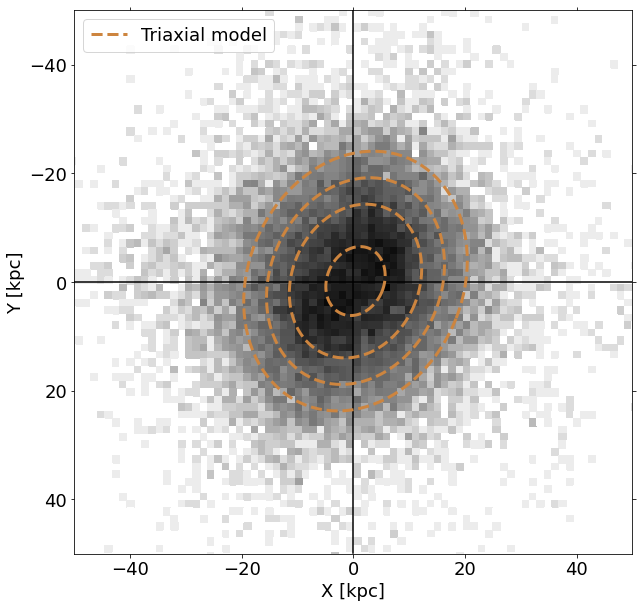

In [65]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist2d(z_05_30.Xg, z_05_30.Yg, bins=150, norm=LogNorm(), cmap=plt.cm.Greys, label="Data")
ax.plot(step, val, 'k', markersize=1.)
ax.plot(val, step, 'k', markersize=1.)
ax.plot(mod_x+Ell_rot11[0,:], mod_y+Ell_rot11[1,:], '--', color='peru', linewidth=3., label="Triaxial model")    #rotated ellipse
ax.plot(mod_x+Ell_rot12[0,:], mod_y+Ell_rot12[1,:], '--', color='peru', linewidth=3.)    #rotated ellipse
ax.plot(mod_x+Ell_rot13[0,:], mod_y+Ell_rot13[1,:], '--', color='peru', linewidth=3.)    #rotated ellipse
ax.plot(mod_x+Ell_rot14[0,:], mod_y+Ell_rot14[1,:], '--', color='peru', linewidth=3.)    #rotated ellipse

ax.set_xlim(-50., 50.)
ax.set_ylim(50., -50.)

ax.set_xlabel('X [kpc]', fontsize=18.)
ax.set_ylabel('Y [kpc]', fontsize=18.)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=True, labelsize=18.) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off
    labelbottom=True, labelsize=18.) # labels along the bottom edge are off

plt.legend(loc='upper left', fontsize=18.)
plt.show()


# plt.savefig('fig3a.png', dpi=300, bbox_inches='tight')

In [66]:
mod_21_x, mod_21_y = mod_x+Ell_rot21[0,:], mod_z+Ell_rot21[1,:]
mod_22_x, mod_22_y = mod_x+Ell_rot22[0,:], mod_z+Ell_rot22[1,:]
mod_23_x, mod_23_y = mod_x+Ell_rot23[0,:], mod_z+Ell_rot23[1,:]
mod_24_x, mod_24_y = mod_x+Ell_rot24[0,:], mod_z+Ell_rot24[1,:]

mod_31_x, mod_31_y = mod_y+Ell_rot31[0,:], mod_z+Ell_rot31[1,:]
mod_32_x, mod_32_y = mod_y+Ell_rot32[0,:], mod_z+Ell_rot32[1,:]
mod_33_x, mod_33_y = mod_y+Ell_rot33[0,:], mod_z+Ell_rot33[1,:]
mod_34_x, mod_34_y = mod_y+Ell_rot34[0,:], mod_z+Ell_rot34[1,:]

In [67]:
mod_21_dict = {'x' : mod_21_x, 'z' : mod_21_y}
mod_22_dict = {'x' : mod_22_x, 'z' : mod_22_y}
mod_23_dict = {'x' : mod_23_x, 'z' : mod_23_y}
mod_24_dict = {'x' : mod_24_x, 'z' : mod_24_y}

mod_31_dict = {'y' : mod_31_x, 'z' : mod_31_y}
mod_32_dict = {'y' : mod_32_x, 'z' : mod_32_y}
mod_33_dict = {'y' : mod_33_x, 'z' : mod_33_y}
mod_34_dict = {'y' : mod_34_x, 'z' : mod_34_y}

mod_21 = pd.DataFrame(mod_21_dict)
mod_22 = pd.DataFrame(mod_22_dict)
mod_23 = pd.DataFrame(mod_23_dict)
mod_24 = pd.DataFrame(mod_24_dict)

mod_31 = pd.DataFrame(mod_31_dict)
mod_32 = pd.DataFrame(mod_32_dict)
mod_33 = pd.DataFrame(mod_33_dict)
mod_34 = pd.DataFrame(mod_34_dict)

In [68]:
mod_21 = mod_21[(abs(mod_21.z) > 5.) & (abs(mod_21.z) < 30.)]
mod_22 = mod_22[(abs(mod_22.z) > 5.) & (abs(mod_22.z) < 30.)]
mod_23 = mod_23[(abs(mod_23.z) > 5.) & (abs(mod_23.z) < 30.)]
mod_24 = mod_24[(abs(mod_24.z) > 5.) & (abs(mod_24.z) < 30.)]

mod_31 = mod_31[(abs(mod_31.z) > 5.) & (abs(mod_31.z) < 30.)]
mod_32 = mod_32[(abs(mod_32.z) > 5.) & (abs(mod_32.z) < 30.)]
mod_33 = mod_33[(abs(mod_33.z) > 5.) & (abs(mod_33.z) < 30.)]
mod_34 = mod_34[(abs(mod_34.z) > 5.) & (abs(mod_34.z) < 30.)]

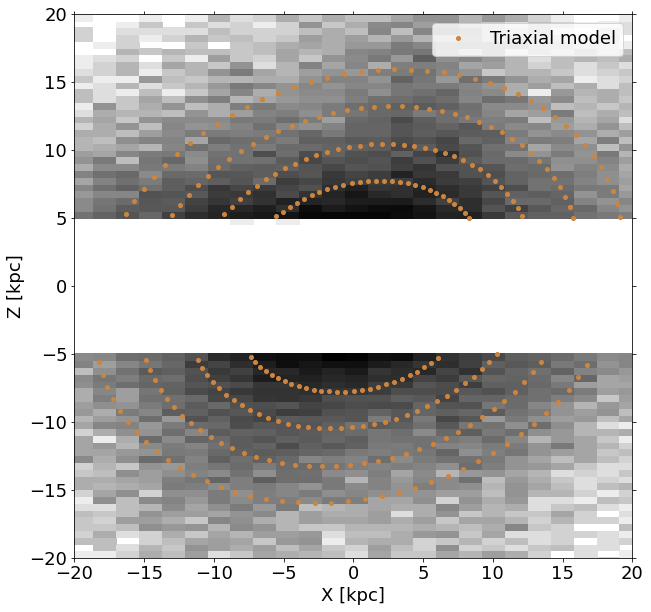

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist2d(z_05_30.Xg, z_05_30.Zg, bins=120, norm=LogNorm(), cmap=plt.cm.Greys)
ax.plot(mod_21.x, mod_21.z, '.', color='peru', markersize=8., label="Triaxial model")    #rotated ellipse
ax.plot(mod_22.x, mod_22.z, '.', color='peru', markersize=8.)    #rotated ellipse
ax.plot(mod_23.x, mod_23.z, '.', color='peru', markersize=8.)    #rotated ellipse
ax.plot(mod_24.x, mod_24.z, '.', color='peru', markersize=8.)    #rotated ellipse

ax.set_xlim(-20., 20.)
ax.set_ylim(-20., 20.)

ax.set_xlabel('X [kpc]', fontsize=18.)
ax.set_ylabel('Z [kpc]', fontsize=18.)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=True, labelsize=18.) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off
    labelbottom=True, labelsize=18.) # labels along the bottom edge are off

plt.legend(loc='best', fontsize=18.)
plt.show()

# plt.savefig('fig3b.png', dpi=300, bbox_inches='tight')

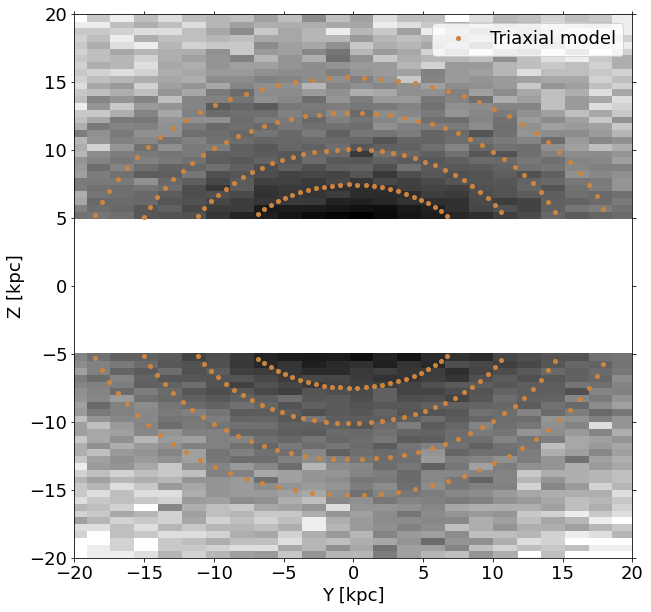

In [70]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist2d(z_05_30.Yg, z_05_30.Zg, bins=120, norm=LogNorm(), cmap=plt.cm.Greys)
ax.plot(mod_31.y, mod_31.z, '.', color='peru', markersize=8., label="Triaxial model")    #rotated ellipse
ax.plot(mod_32.y, mod_32.z, '.', color='peru', markersize=8.)    #rotated ellipse
ax.plot(mod_33.y, mod_33.z, '.', color='peru', markersize=8.)    #rotated ellipse
ax.plot(mod_34.y, mod_34.z, '.', color='peru', markersize=8.)    #rotated ellipse

ax.set_xlim(-20., 20.)
ax.set_ylim(-20., 20.)

ax.set_xlabel('Y [kpc]', fontsize=18.)
ax.set_ylabel('Z [kpc]', fontsize=18.)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=True, labelsize=18.) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off
    labelbottom=True, labelsize=18.) # labels along the bottom edge are off

plt.legend(loc='best', fontsize=18.)
plt.show()

# plt.savefig('fig3c.png', dpi=300, bbox_inches='tight')